# Paragraph causal relation detection: do they contain a causal relation or not

**Example**: '3-2: <span style="background-color: lightblue;">[concept Giving to the ECB the ultimate responsibility for supervision of banks in the euro area concept]</span> <span style="background-color: pink;">[explanation will decisively contribute to increase explanation]</span> <span style="background-color: lightblue;">[concept confidence between the banks concept]</span> <span style="background-color: pink;">[explanation and in this way increase explanation]</span> <span style="background-color: lightblue;">[concept the financial stability in the euro area concept]</span>. The euro area governments and the European institutions, including naturally the European Commission and the ECB, will do whatever is necessary to secure the financial stability of the euro area.\n'

## 1. Load data

This notebook expects three files in a subdirectory `csv`: `Map_Contents-20200726.csv`, `Speech_Contents-20210520.txt` and `Speeches-20210520.txt`. It will look for files with the speeches in the subdirectory `txt`. The names of the speech files are expected to start with the date followed by a space and the suname of the speaker (currently restricted to one word, see function `get_speech_id`).

If you are just interested in learning what the code is doing, you can skip all code blocks with the commands `import` (load libraries), `assert` (perform tests) and `def` (define functions), and examine the other code blocks.

In [1]:
cd ..

F:\PythonJupyterStudy\CM\CM_Macro\SSIML2021-macro-precision


In [62]:
import os
from src.data.make_dataset import read_data_file
from src.data.make_dataset import make_dataset
import fasttext
from langdetect import detect
from nltk.tokenize import word_tokenize
import numpy as np
import re
import sklearn
from sklearn.metrics import classification_report
from sklearn.utils import shuffle,resample
import pandas as pd
from termcolor import colored
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools

In [3]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

## 2. Predict presence of causal relations in paragraphs

Steps:

1. store the paragraphs in the data structure X (data) after separating punctuation from words and replacing upper case by lower case
2. create a data structure y (labels) with True for paragraphs with causal relations and False for others
3. predict a label for each paragraph with a machine learning model generated from the other paragraphs
4. evaluate the results

The code in this task uses the packages `fasttext` (for machine learning) and `nltk` (for language processing) 

The task uses limited natural language processing to prepare the data for machine leaning:

1. tokenization: separate punctuation from words
2. conversion of upper case characters to lower case

Other interesting natural language preprocessing steps:

3. part-of-tagging
4. full parsing (Stanford parser)

In [69]:
def make_train_test(X, y, test_index=0):
    train_list = []
    test_list = []
    index = 0
    for key in sorted(X.keys()):
        if index == test_index:
            test_list.append(f"__label__{str(y[key])} {X[key]}")
        else:
            train_list.append(f"__label__{str(y[key])} {X[key]}")
        index += 1
    return train_list, test_list

def make_train_file(file_name, train_list):
    data_file = open(file_name, "w",encoding='utf-8')
    for line in train_list:
        print(line, file=data_file)
    data_file.close()

def decode_label(label):
    return re.sub("__label__", "", label) == "True"

def show_results(results):
    result_list = []
    for key in results:
        result_list.append({"paragraph": key})
        result_list[-1].update(results[key])
    return pd.DataFrame(result_list, index=[""]*len(result_list))

def count_y_values(y):
    values = {}
    for key in y:
        if y[key] not in values:
            values[y[key]] = 0
        values[y[key]] += 1
    table = []
    for key in values:
        table.append({"label": key, "count": values[key], "percentage": f"{round(100*values[key]/len(y), 1)}%"})
    return pd.DataFrame(table, index=[""]*len(table))

def squeal(text):
    clear_output(wait=True)
    print(text)

def make_fasttext_data(data_in):
    data_out = []
    for paragraph, label in data_in:
        data_out.append("__label__" + str(label) + " " + paragraph)
    return data_out

def run_experiments(X, y, wordNgrams=1, pretrainedVectors=""):
    y_pred = []
    y_true = [ y[key] for key in X if key in y]
    counter = 0
    data = np.array([ (X[key], y[key]) for key in X if key in y])
    for train_items, test_items in sklearn.model_selection.KFold(n_splits=10).split(X):
        train_data = make_fasttext_data(data[train_items])
        make_train_file("train_file.txt", train_data)
        model = fasttext.train_supervised("train_file.txt", dim=300, pretrainedVectors=pretrainedVectors, wordNgrams=wordNgrams)
        test_data = make_fasttext_data(data[test_items])
        predicted_labels = model.predict(test_data)
        y_pred.extend(predicted_labels[0])
        counter += 1
        squeal(f"Ran experiment {counter} of 10")
        
    y_pred = [decode_label(label[0]) for label in y_pred]
    return y_true, y_pred

def evaluate_results(y_true, y_pred):
    precision, recall, fscore, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"Precision: {precision:0.3f}; recall: {recall:0.3f}; F1: {fscore:0.3f}")

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

The variable `X` in the next code block contains all the data (paragraphs) available for machine learning. The variable `y` contains all the associated labels, with values `True` or `False`.   

In [19]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### 2. Balance data

In [20]:
count_y_values(y)

,label,count,percentage
,True,660,73.6%
,False,237,26.4%


1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.

In [24]:
def balance_data(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=42,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('We totally have {} data after oversampling '.format(len(df_upsampled)))
    
    #downsampling
    df_true_downsampled = resample(df_true,random_state=42,n_samples=len(df_false),replace=False)
    df_downsampled = pd.concat([df_true_downsampled,df_false])
    df_downsampled = shuffle(df_downsampled)
    print('We totally have {} data after Undersampling '.format(len(df_downsampled)))
    
    
    return df_upsampled,df_downsampled

In [25]:
df_upsampled,df_downsampled = balance_data(X,y)

19 na data found
na data dropped
We totally have 1282 data after oversampling 
We totally have 474 data after Undersampling 


We run 10 experiments for 10 different splits. In each machine learning experiment, one part of the data is used as test data while all others are used for training a machine learning model to predict the labels of this part. 

### 3. N-gram models

### <center>Understand confusion matrix<center>


![](https://miro.medium.com/max/693/1*7EYylA6XlXSGBCF77j_rOA.png)
    
<center>$Recall: \Large\frac{TP}{TP+FN}$ $\quad\quad\quad\quad Precision: \Large\frac{TP}{TP+FP}$<center><br>
<center>$F1: \Large\frac{2*Recall*Precision}{Recall+Precision}$<center>

* <h3>Using un-balanced data

Ran experiment 10 of 10
------------------------Uni-gram model------------------------
              precision    recall  f1-score   support

     class 0       1.00      0.03      0.05       237
     class 1       0.74      1.00      0.85       641

    accuracy                           0.74       878
   macro avg       0.87      0.51      0.45       878
weighted avg       0.81      0.74      0.63       878



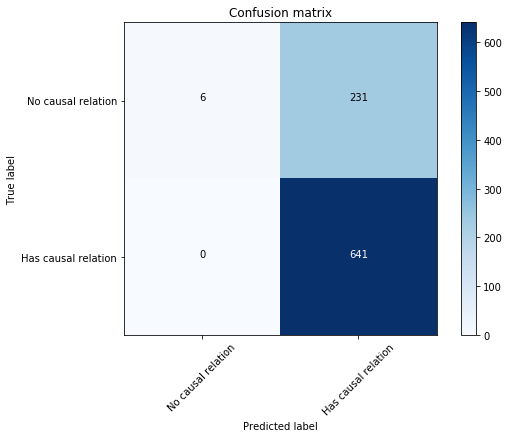

In [71]:
#Unigram
y_true, y_pred = run_experiments(X, y, wordNgrams=1)
target_names = ['class 0', 'class 1']
print('------------------------Uni-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Bi-gram model------------------------
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       237
     class 1       0.73      1.00      0.84       641

    accuracy                           0.73       878
   macro avg       0.37      0.50      0.42       878
weighted avg       0.53      0.73      0.62       878



F:\anaconda\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


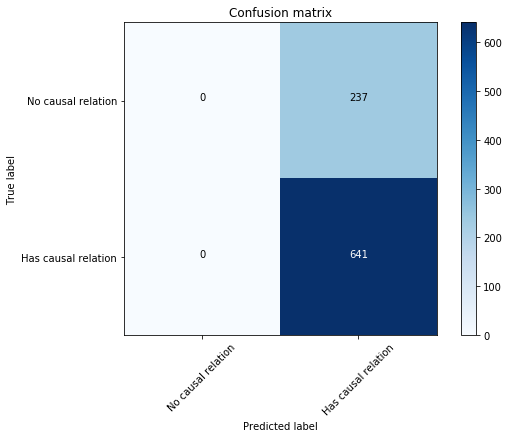

In [75]:
#Bi-gram
y_true, y_pred = run_experiments(X, y, wordNgrams=2)
print('------------------------Bi-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Tri-gram model------------------------
              precision    recall  f1-score   support

     class 0       1.00      0.01      0.02       237
     class 1       0.73      1.00      0.85       641

    accuracy                           0.73       878
   macro avg       0.87      0.51      0.44       878
weighted avg       0.80      0.73      0.62       878



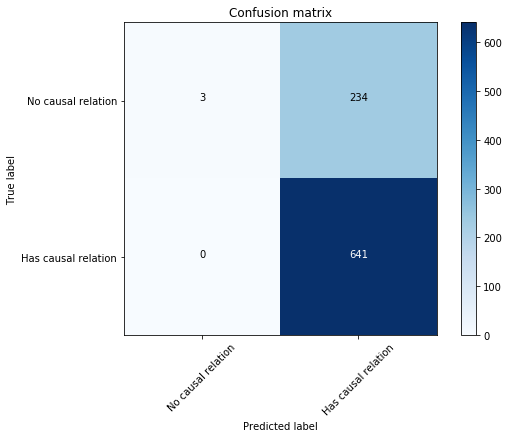

In [76]:
#Tri-gram
y_true, y_pred = run_experiments(X, y, wordNgrams=3)
print('------------------------Tri-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

* <h3>Using balanced data (Oversampling and Undersampling)

Ran experiment 10 of 10
------------------------Uni-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       1.00      0.03      0.05       218
     class 1       0.75      1.00      0.86       641

    accuracy                           0.75       859
   macro avg       0.88      0.51      0.46       859
weighted avg       0.81      0.75      0.65       859



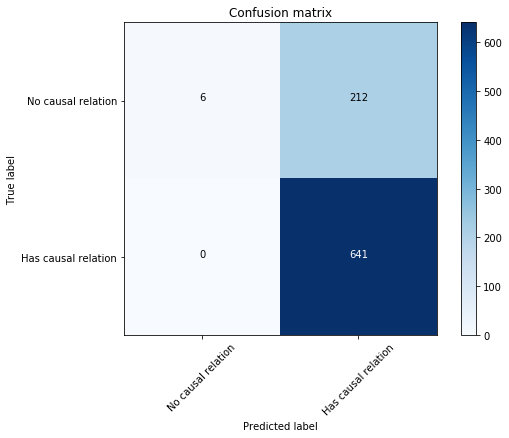


Downsampling
              precision    recall  f1-score   support

     class 0       0.60      0.14      0.22       237
     class 1       0.51      0.91      0.66       237

    accuracy                           0.52       474
   macro avg       0.56      0.52      0.44       474
weighted avg       0.56      0.52      0.44       474



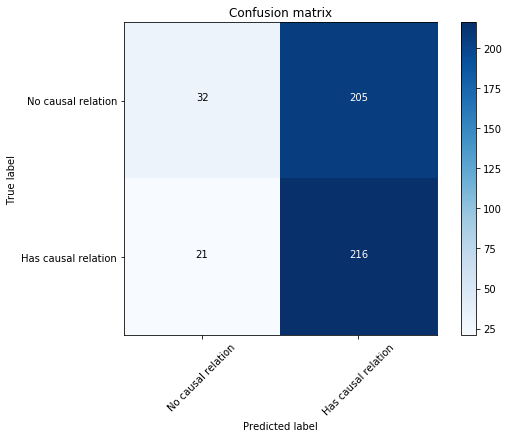

In [81]:
#Uni-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=1)
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=1)
print('------------------------Uni-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Bi-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       218
     class 1       0.75      1.00      0.85       641

    accuracy                           0.75       859
   macro avg       0.37      0.50      0.43       859
weighted avg       0.56      0.75      0.64       859



F:\anaconda\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


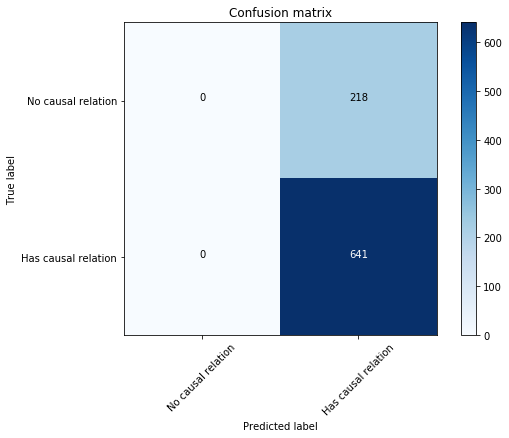


Downsampling
              precision    recall  f1-score   support

     class 0       0.59      0.17      0.27       237
     class 1       0.51      0.88      0.65       237

    accuracy                           0.53       474
   macro avg       0.55      0.53      0.46       474
weighted avg       0.55      0.53      0.46       474



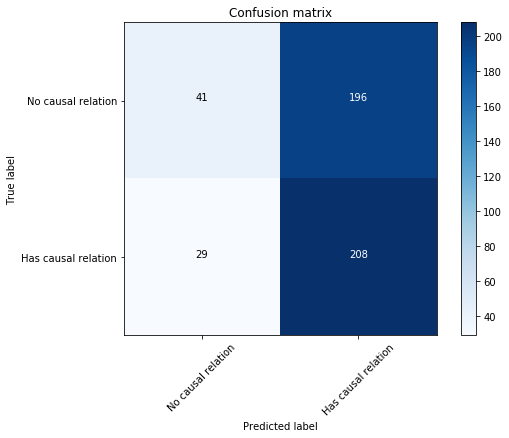

In [82]:
#Bi-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=2)
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=2)
print('------------------------Bi-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Tri-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       1.00      0.00      0.01       218
     class 1       0.75      1.00      0.86       641

    accuracy                           0.75       859
   macro avg       0.87      0.50      0.43       859
weighted avg       0.81      0.75      0.64       859



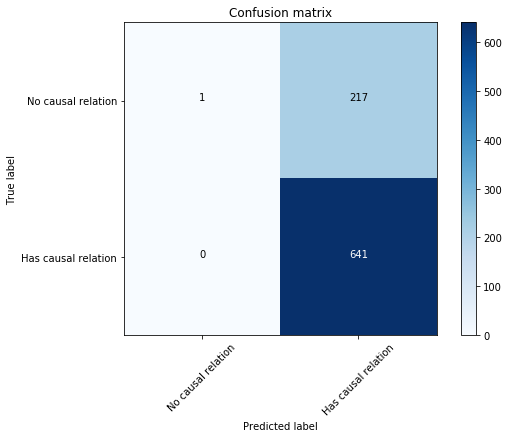


Downsampling
              precision    recall  f1-score   support

     class 0       0.59      0.20      0.30       237
     class 1       0.52      0.86      0.65       237

    accuracy                           0.53       474
   macro avg       0.56      0.53      0.47       474
weighted avg       0.56      0.53      0.47       474



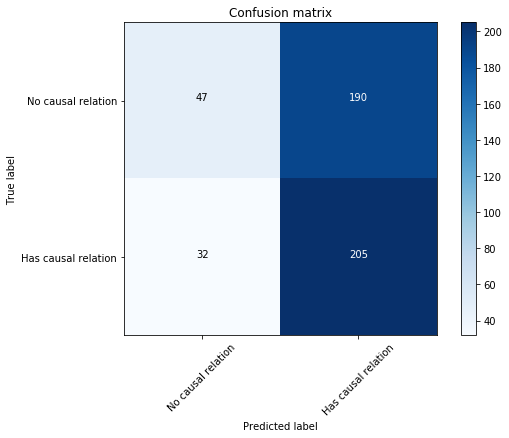

In [83]:
#Tri-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=3)
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=3)
print('------------------------Tri-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

#### To sum up:<br>
* As can be seen, after using balanced data, it is also difficult to determine whether a paragraph has a causal relationship in our n-gram model.<br>
* Among them, for the model using oversampling, they have basically *0* f1 values for "class 0", which means that the classifier is basically unable to distinguish a passage without causality.<br>
* The performance of the undersampling model is slightly better, but it does not meet our expectation.


| ngrams | Balanced-data | macro precision | macro recall | macro F1    |
| ------ | -------------- | --------- | ------ | ---- |
| 1      | no             | 0.87     | 0.51  | 0.45 |
| 2      | no             | 0.37     | 0.50  | 0.42 |
| 3      | no             | 0.87     | 0.51  | 0.44 |
| 1      | yes(oversampling)   | 0.88     | 0.51  | 0.46 |
| 1      | yes(undersampling)   | 0.56     | 0.52 | 0.44 |
| 2      | yes(oversampling)    | 0.37     | 0.50 | 0.43 |
| 2      | yes(undersampling)   | 0.55     | 0.53 | 0.46 |
| 3      | yes(oversampling)    | 0.87     | 0.50  | 0.43 |
| 3      | yes(undersampling)   | 0.56     | 0.53  | 0.47 |

### 4. N-gram models with pre-trained word embedding

* Fast-text pretrained word embedding (The training time will be extremely long)<br>
* <h4>Using un-balanced data

Ran experiment 10 of 10
------------------------Uni-gram model------------------------
              precision    recall  f1-score   support

     class 0       0.52      0.41      0.46       237
     class 1       0.80      0.86      0.83       641

    accuracy                           0.74       878
   macro avg       0.66      0.63      0.64       878
weighted avg       0.72      0.74      0.73       878



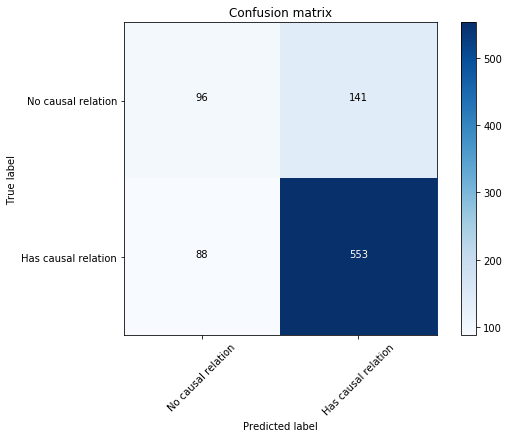

In [84]:
#Unigram
y_true, y_pred = run_experiments(X, y, wordNgrams=1, pretrainedVectors='wiki.en.vec')
target_names = ['class 0', 'class 1']
print('------------------------Uni-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Bi-gram model------------------------
              precision    recall  f1-score   support

     class 0       0.57      0.32      0.42       237
     class 1       0.78      0.91      0.84       641

    accuracy                           0.75       878
   macro avg       0.68      0.62      0.63       878
weighted avg       0.73      0.75      0.73       878



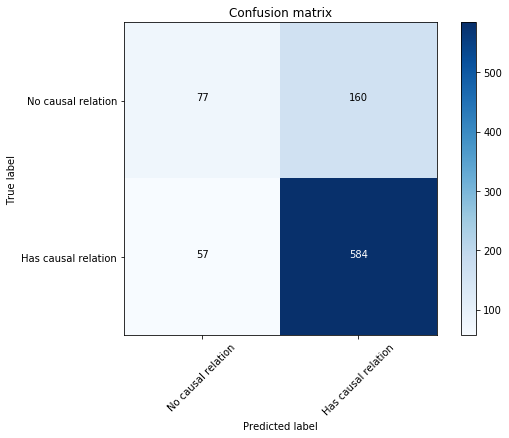

In [85]:
#Bi-gram
y_true, y_pred = run_experiments(X, y, wordNgrams=2, pretrainedVectors='wiki.en.vec')
print('------------------------Bi-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Tri-gram model------------------------
              precision    recall  f1-score   support

     class 0       0.59      0.24      0.35       237
     class 1       0.77      0.94      0.85       641

    accuracy                           0.75       878
   macro avg       0.68      0.59      0.60       878
weighted avg       0.72      0.75      0.71       878



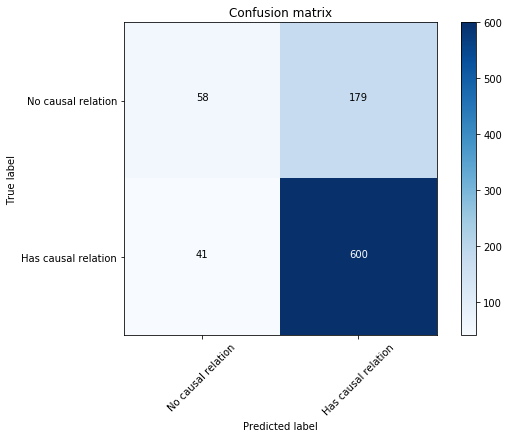

In [86]:
#Tri-gram
y_true, y_pred = run_experiments(X, y, wordNgrams=3, pretrainedVectors='wiki.en.vec')
print('------------------------Tri-gram model------------------------')
print(classification_report(y_true, y_pred, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

* <h4>Using balanced data(Oversampling and Undersampling)

Ran experiment 10 of 10
------------------------Uni-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       0.55      0.40      0.46       218
     class 1       0.81      0.89      0.85       641

    accuracy                           0.76       859
   macro avg       0.68      0.64      0.66       859
weighted avg       0.75      0.76      0.75       859



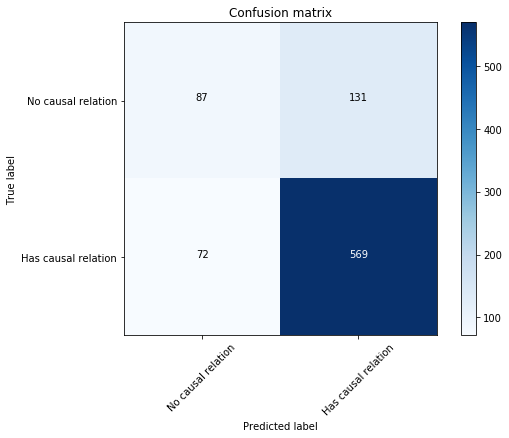


Downsampling
              precision    recall  f1-score   support

     class 0       0.64      0.61      0.62       237
     class 1       0.63      0.65      0.64       237

    accuracy                           0.63       474
   macro avg       0.63      0.63      0.63       474
weighted avg       0.63      0.63      0.63       474



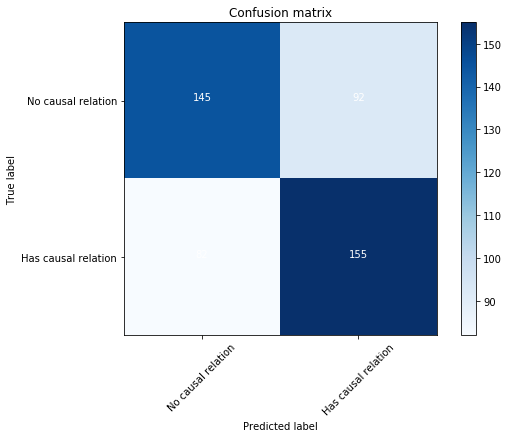

In [87]:
#Uni-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=1, pretrainedVectors='wiki.en.vec')
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=1, pretrainedVectors='wiki.en.vec')
print('------------------------Uni-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Bi-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       0.56      0.28      0.38       218
     class 1       0.79      0.93      0.85       641

    accuracy                           0.76       859
   macro avg       0.68      0.60      0.62       859
weighted avg       0.73      0.76      0.73       859



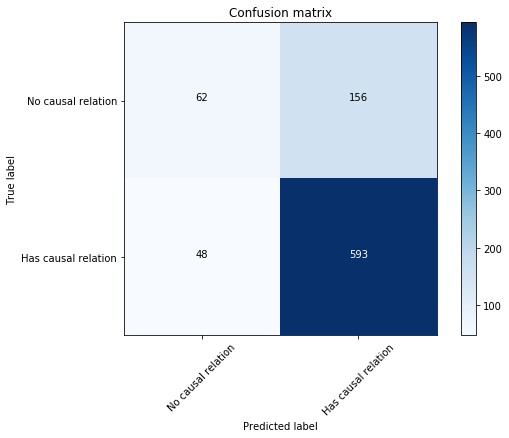


Downsampling
              precision    recall  f1-score   support

     class 0       0.65      0.59      0.62       237
     class 1       0.62      0.68      0.65       237

    accuracy                           0.63       474
   macro avg       0.63      0.63      0.63       474
weighted avg       0.63      0.63      0.63       474



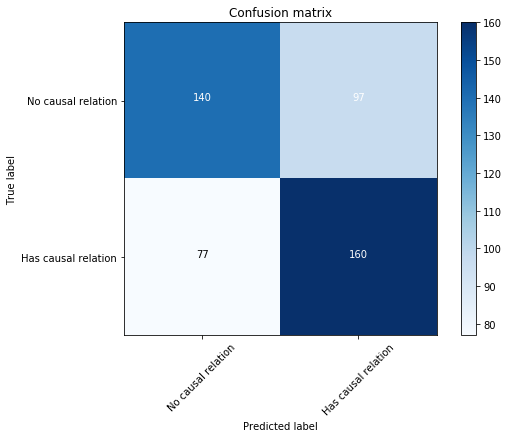

In [88]:
#Bi-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=2, pretrainedVectors='wiki.en.vec')
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=2, pretrainedVectors='wiki.en.vec')
print('------------------------Bi-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

Ran experiment 10 of 10
------------------------Tri-gram model------------------------
Oversampling
              precision    recall  f1-score   support

     class 0       0.54      0.20      0.29       218
     class 1       0.78      0.94      0.85       641

    accuracy                           0.75       859
   macro avg       0.66      0.57      0.57       859
weighted avg       0.72      0.75      0.71       859



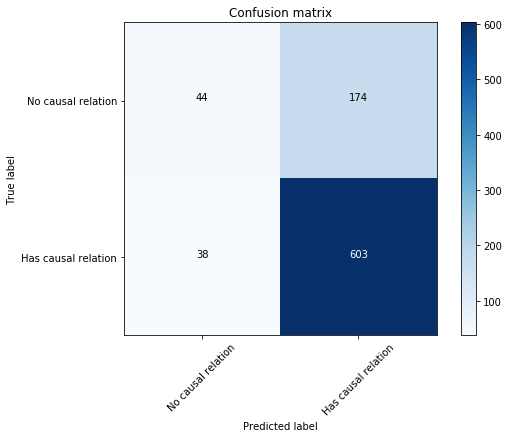


Downsampling
              precision    recall  f1-score   support

     class 0       0.68      0.60      0.64       237
     class 1       0.64      0.72      0.68       237

    accuracy                           0.66       474
   macro avg       0.66      0.66      0.66       474
weighted avg       0.66      0.66      0.66       474



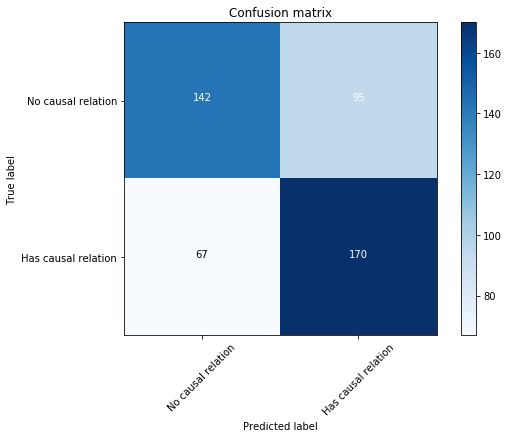

In [89]:
#Tri-gram
X_up =  df_upsampled['X'].to_dict()
y_up =  df_upsampled['y'].to_dict()
y_true_up, y_pred_up = run_experiments(X_up, y_up, wordNgrams=3, pretrainedVectors='wiki.en.vec')
y_true_down, y_pred_down = run_experiments(X_down, y_down, wordNgrams=3, pretrainedVectors='wiki.en.vec')
print('------------------------Tri-gram model------------------------')
print('Oversampling')
print(classification_report(y_true_up, y_pred_up, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_up, y_pred_up)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

print('\nDownsampling')
print(classification_report(y_true_down, y_pred_down, target_names=target_names))
cm = sklearn.metrics.confusion_matrix(y_true_down, y_pred_down)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

#### To sum up:<br>
* As can be seen, even using balanced data, the overall performance of models is barely improved.<br>
* However, both balancing data improve the precision and recall values for class 0. Among them, undersampling is more effectual, however, at the cost of losing some data for class 1, which leads to a decrease in the recognition accuracy for class 1.<br>
* The use of pre-trained word embeddings significantly improves the performance of the n-gram model, based on a significant increase in training time. However, even after using the balanced data, the final results did not meet our expectations.

Pre-trained WE| ngrams | Balanced-data | macro precision | macro recall | macro F1 |
------------  | ------ | -------------- | --------- | ------ | ---- |
       yes | 1      | no             | 0.66     | 0.63  | 0.64 |
       yes | 2      | no             | 0.68     | 0.62  | 0.63 |
       yes | 3      | no             | 0.68     | 0.59  | 0.60 |    
       yes | 1      | oversampling        | 0.68     | 0.64  | 0.66 |
       yes | 1      | undersampling       | 0.63     | 0.63  | 0.63 |
       yes | 2      | oversampling        | 0.68     | 0.60  | 0.62 |
       yes | 2      | undersampling       | 0.63     | 0.63  | 0.63 |
       yes | 3      | oversampling        | 0.66     | 0.57  | 0.57 |
       yes | 3      | undersampling       | 0.66     | 0.66  | 0.66 |
------------  | ------ | -------------- | --------- | ------ | ---- |
       no | 1      | no             | 0.87     | 0.51  | 0.45 |
       no | 2      | no             | 0.37     | 0.50  | 0.42 |
       no | 3      | no             | 0.87     | 0.51  | 0.44 |